### Plots, loading from /g/data processed files


In [1]:
#Load required packages
%matplotlib inline
import matplotlib.pyplot as plt
import xarray as xr
from xgcm import Grid
import numpy as np
import pandas as pd
import cftime
import IPython.display
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft
import sys, os
import warnings
warnings.simplefilter("ignore")
from dask.distributed import Client

from xhistogram.xarray import histogram


In [2]:
client = Client(n_workers=8)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 8
Total threads: 8,Total memory: 250.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35323,Workers: 8
Dashboard: /proxy/8787/status,Total threads: 8
Started: Just now,Total memory: 250.00 GiB
Comm: tcp://127.0.0.1:34817,Total threads: 1
Dashboard: /proxy/43031/status,Memory: 31.25 GiB
Nanny: tcp://127.0.0.1:34989,


In [3]:
## load stuff for grid info

# files:
base = '/g/data/hh5/tmp/cy8964/access-om2/archive/025deg_jra55_ryf/';
xch = 1440#*10#2*288
ych = 1080#*10#2*216

fgrd   = xr.open_dataset(base + 'output096/ocean/ocean_grid.nc').chunk({'yt_ocean':ych/10,'yu_ocean':ych/10,'xt_ocean':xch/10,'xu_ocean':xch/10})
fwmass_mean = xr.open_mfdataset(base +'output096/ocean/ocean_wmass_mean.nc').chunk({'grid_yt_ocean':ych/10,'grid_yu_ocean':ych/10,'grid_xt_ocean':xch/10})
fmonth_mean = xr.open_mfdataset(base +'output096/ocean/ocean_month_mean.nc').chunk({'yt_ocean':ych/10,'yu_ocean':ych/10,'xt_ocean':xch/10})
fheat_mean = xr.open_mfdataset(base +'output096/ocean/ocean_heat_mean.nc').chunk({'yt_ocean':ych/10,'xt_ocean':xch/10})

# load RYF monthly data
base_msc = '/g/data/hh5/tmp/cy8964/access-om2/archive/025deg_jra55_ryf/'
# ---------------------------------------------------------------------------------- #
# load in data set ----------------------------------------------------------------- #
fmonth_m = xr.open_mfdataset(base_msc+'output096/ocean/ocean_month.nc',combine='by_coords',chunks={'time': 1},decode_times = True).chunk({'time': 1,'yt_ocean':ych/10,'xt_ocean':xch/10})
fheat_m = xr.open_mfdataset(base_msc+'output096/ocean/ocean_heat.nc',combine='by_coords',chunks={'time': 1},decode_times = True).chunk({'time': 1,'yt_ocean':ych/10,'xt_ocean':xch/10})
fwmass_m = xr.open_mfdataset(base_msc+'output096/ocean/ocean_wmass.nc',combine='by_coords',chunks={'time': 1},decode_times = True).chunk({'time': 1,'grid_yt_ocean':ych/10,'grid_xt_ocean':xch/10})

# load RYF daily data
base_msc = '/g/data/hh5/tmp/cy8964/access-om2/archive/025deg_jra55_ryf/'
# ---------------------------------------------------------------------------------- #
# load in data set ----------------------------------------------------------------- #
fdaily = xr.open_mfdataset(base_msc+'output096/ocean/ocean_daily.nc',combine='by_coords',chunks={'time': 1},decode_times = True).chunk({'time': 1,'yt_ocean':ych/10,'xt_ocean':xch/10})
fheat_daily = xr.open_mfdataset(base_msc+'output096/ocean/ocean_heat_daily.nc',combine='by_coords',chunks={'time': 1},decode_times = True).chunk({'time': 1,'yt_ocean':ych/10,'xt_ocean':xch/10})
fwmass_daily = xr.open_mfdataset(base_msc+'output096/ocean/ocean_wmass_daily.nc',combine='by_coords',chunks={'time': 1},decode_times = True).chunk({'time': 1,'grid_yt_ocean':ych/10,'grid_xt_ocean':xch/10})

# ---------------------------------------------------------------------------------- #

# Generate xgcm grid object:
gridwm = Grid(fwmass_m,coords={"x":{"center":"grid_xt_ocean","right":"grid_xu_ocean"},
                             "y":{"center":"grid_yt_ocean","right":"grid_yu_ocean"},
                             "T":{"center":"neutral","outer":"neutralrho_edges"}},periodic=False)
gridmn = Grid(fmonth_m,coords={"x":{"center":"xt_ocean"},
                             "y":{"center":"yt_ocean","right":"yu_ocean"},
                             "z":{"center":"st_ocean","outer":"st_edges_ocean"}},periodic=False)
gridht = Grid(fheat_m,coords={"x":{"center":"xt_ocean"},
                             "y":{"center":"yt_ocean"},
                             "z":{"center":"st_ocean","outer":"st_edges_ocean"}},periodic=False)
gridd = Grid(fdaily,coords={"x":{"center":"xt_ocean"},
                             "y":{"center":"yt_ocean","right":"yu_ocean"},
                             "z":{"center":"st_ocean","outer":"st_edges_ocean"}},periodic=False)
grid2 = Grid(fgrd,coords={"x":{"center":"xt_ocean","right":"xu_ocean"},
                             "y":{"center":"yt_ocean","right":"yu_ocean"}},periodic=False)

# ---------------------------------------------------------------------------------- #

# Some constants:
Cp = 3992.10322329649
rho0 = 1035
dT = (fwmass_m.neutral[1]-fwmass_m.neutral[0]).values

sc_daylength = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

area = fgrd.area_t.rename({'xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
dy = gridmn.diff(fgrd.yu_ocean,'y',boundary='extend').rename({'yt_ocean':'grid_yt_ocean'})
dx = grid2.diff(fgrd.xu_ocean,'x',boundary='extend').rename({'xt_ocean':'grid_xt_ocean'})
dyt = gridmn.diff(fgrd.yu_ocean,'y',boundary='extend')
dxt = grid2.diff(fgrd.xu_ocean,'x',boundary='extend')

### Load 3d (x,y,temp) data separated by timescale

In [4]:
# True_1year_means = xr.open_mfdataset('/g/data/e14/cy8964/Post_Process/temp/025deg_096_3d/True_1year_means_corrected.nc').chunk({'grid_yu_ocean':ych/10,'grid_yt_ocean':ych/10, 'grid_xt_ocean':xch/10})
# Mean_1year_means = xr.open_mfdataset('/g/data/e14/cy8964/Post_Process/temp/025deg_096_3d/Mean_1year_means.nc').chunk({'grid_yu_ocean':ych/10,'grid_yt_ocean':ych/10, 'grid_xt_ocean':xch/10})
# Twomo_mean_1year_means = xr.open_mfdataset('/g/data/e14/cy8964/Post_Process/temp/025deg_096_3d/2mo_mean_1year_means.nc').chunk({'grid_yu_ocean':ych/10,'grid_yt_ocean':ych/10, 'grid_xt_ocean':xch/10})
# Tenday_mean_1year_means = xr.open_mfdataset('/g/data/e14/cy8964/Post_Process/temp/025deg_096_3d/10day_mean_1year_means.nc').chunk({'grid_yu_ocean':ych/10,'grid_yt_ocean':ych/10, 'grid_xt_ocean':xch/10})
# Oneday_mean_1year_means = xr.open_mfdataset('/g/data/e14/cy8964/Post_Process/temp/025deg_096_3d/1day_mean_1year_means.nc').chunk({'grid_yu_ocean':ych/10,'grid_yt_ocean':ych/10,'grid_xt_ocean':xch/10})

True_10year_means = xr.open_mfdataset('/g/data/e14/cy8964/Post_Process/temp/025deg_10yr_3d/True_10year_means.nc')#.chunk({'grid_yu_ocean':ych/10,'grid_yt_ocean':ych/10, 'grid_xt_ocean':xch/10})
Mean_10year_means = xr.open_mfdataset('/g/data/e14/cy8964/Post_Process/temp/025deg_10yr_3d/Mean_10year_means.nc')#.chunk({'grid_yu_ocean':ych/10,'grid_yt_ocean':ych/10, 'grid_xt_ocean':xch/10})
Twomo_mean_10year_means = xr.open_mfdataset('/g/data/e14/cy8964/Post_Process/temp/025deg_10yr_3d/2mo_mean_10year_means.nc')#.chunk({'grid_yu_ocean':ych/10,'grid_yt_ocean':ych/10, 'grid_xt_ocean':xch/10})
sc_Twomo_mean_10year_means = xr.open_mfdataset('/g/data/e14/cy8964/Post_Process/temp/025deg_10yr_3d/sc_2mo_mean_10year_means.nc')#.chunk({'grid_yu_ocean':ych/10,'grid_yt_ocean':ych/10, 'grid_xt_ocean':xch/10})
Tenday_mean_10year_means = xr.open_mfdataset('/g/data/e14/cy8964/Post_Process/temp/025deg_10yr_3d/10day_mean_10year_means.nc')#.chunk({'grid_yu_ocean':ych/10,'grid_yt_ocean':ych/10, 'grid_xt_ocean':xch/10})
Oneday_mean_10year_means = xr.open_mfdataset('/g/data/e14/cy8964/Post_Process/temp/025deg_10yr_3d/1day_mean_10year_means.nc')#.chunk({'grid_yu_ocean':ych/10,'grid_yt_ocean':ych/10,'grid_xt_ocean':xch/10})


# Nice Plots for Paper

In [5]:
Psi = True_10year_means.Psi
Psi_mean_tot = Mean_10year_means.Psi
Psi_ac = (sc_Twomo_mean_10year_means - Mean_10year_means).Psi
Psi_lt = (Twomo_mean_10year_means - sc_Twomo_mean_10year_means).Psi

Psi_TIWs = (Tenday_mean_10year_means - Twomo_mean_10year_means).Psi
Psi_storm = (Oneday_mean_10year_means- Tenday_mean_10year_means).Psi
Psi_diurnal = (True_10year_means-Oneday_mean_10year_means).Psi

In [6]:
SF = True_10year_means.SF
SF_mean_tot = Mean_10year_means.SF
SF_ac = (sc_Twomo_mean_10year_means - Mean_10year_means).SF
SF_lt = (Twomo_mean_10year_means - sc_Twomo_mean_10year_means).SF

SF_TIWs = (Tenday_mean_10year_means - Twomo_mean_10year_means).SF
SF_storm = (Oneday_mean_10year_means- Tenday_mean_10year_means).SF
SF_diurnal = (True_10year_means-Oneday_mean_10year_means).SF

In [7]:
MX = True_10year_means.MX
MX_mean_tot = Mean_10year_means.MX
MX_ac = (sc_Twomo_mean_10year_means - Mean_10year_means).MX
MX_lt = (Twomo_mean_10year_means - sc_Twomo_mean_10year_means).MX

MX_TIWs = (Tenday_mean_10year_means - Twomo_mean_10year_means).MX
MX_storm = (Oneday_mean_10year_means- Tenday_mean_10year_means).MX
MX_diurnal = (True_10year_means-Oneday_mean_10year_means).MX

In [8]:
Hf = -Cp*rho0*dT*gridwm.cumsum(True_10year_means.Psi,'T',boundary="fill", fill_value=0)
Hf_mean_tot = -Cp*rho0*dT*gridwm.cumsum(Mean_10year_means.Psi,'T',boundary="fill", fill_value=0)
Hf_ac = -Cp*rho0*dT*gridwm.cumsum((sc_Twomo_mean_10year_means - Mean_10year_means).Psi,'T',boundary="fill", fill_value=0)
Hf_lt = -Cp*rho0*dT*gridwm.cumsum((Twomo_mean_10year_means - sc_Twomo_mean_10year_means).Psi,'T',boundary="fill", fill_value=0)

Hf_TIWs = -Cp*rho0*dT*gridwm.cumsum((Tenday_mean_10year_means - Twomo_mean_10year_means).Psi,'T',boundary="fill", fill_value=0)
Hf_storm = -Cp*rho0*dT*gridwm.cumsum((Oneday_mean_10year_means- Tenday_mean_10year_means).Psi,'T',boundary="fill", fill_value=0)
Hf_diurnal = -Cp*rho0*dT*gridwm.cumsum((True_10year_means-Oneday_mean_10year_means).Psi,'T',boundary="fill", fill_value=0)


## Zonal mean plots

In [9]:
# masking:
maskPsi = 0*True_10year_means.Psi.sum('grid_xt_ocean').where(True_10year_means.Psi.sum('grid_xt_ocean')!=True_10year_means.Psi.sum('grid_xt_ocean').isel(neutralrho_edges=-1))+1.
maskHf = gridwm.interp(maskPsi,'T')
maskSF = gridwm.interp(maskPsi,'y',boundary="fill",fill_value=0.)
maskSF


<xarray.DataArray 'mul-b7cbe726caf7dd7f32980cca34702a46' (neutralrho_edges: 75,
                                                          grid_yt_ocean: 1080)>
dask.array<mul, shape=(75, 1080), dtype=float64, chunksize=(75, 1079), chunktype=numpy.ndarray>
Coordinates:
  * neutralrho_edges  (neutralrho_edges) float64 -3.0 -2.5 -2.0 ... 33.5 34.0
  * grid_yt_ocean     (grid_yt_ocean) float64 -81.08 -80.97 ... 89.84 89.95

In [10]:
def plot_max_temp(grid):
    if grid =='Psi':
        cb = (maskPsi+1).fillna(0)
        cb.plot.contour(levels = [0.5], linestyles = 'dotted', colors = 'k', linewidths = 0.5)
    if grid =='Hf':
        cb = (maskHf+1).fillna(0)
        cb.plot.contour(levels = [0.5], linestyles = 'dotted', colors = 'k', linewidths = 0.5)
    if grid =='SF':
        cb = (maskSF+1).fillna(0)
        cb.plot.contour(levels = [0.5], linestyles = 'dotted', colors = 'k', linewidths = 0.5)
        

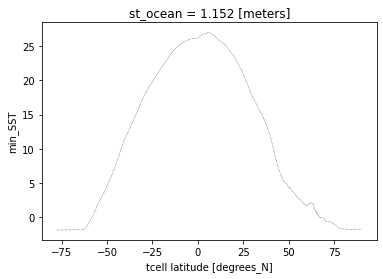

In [11]:
## Min temp
min_SST = xr.open_mfdataset('/g/data/e14/cy8964/Post_Process/temp/025deg_10yr_3d/min_SST_10yr_daily_data.nc').min_SST

(min_SST-273.15).mean('xt_ocean').plot(linestyle = 'dotted',color = 'k',linewidth = 0.5)


In [12]:
def plot_min_temp():
    (min_SST-273.15).mean('xt_ocean').plot(linestyle = 'dotted',color = 'k',linewidth = 0.5)


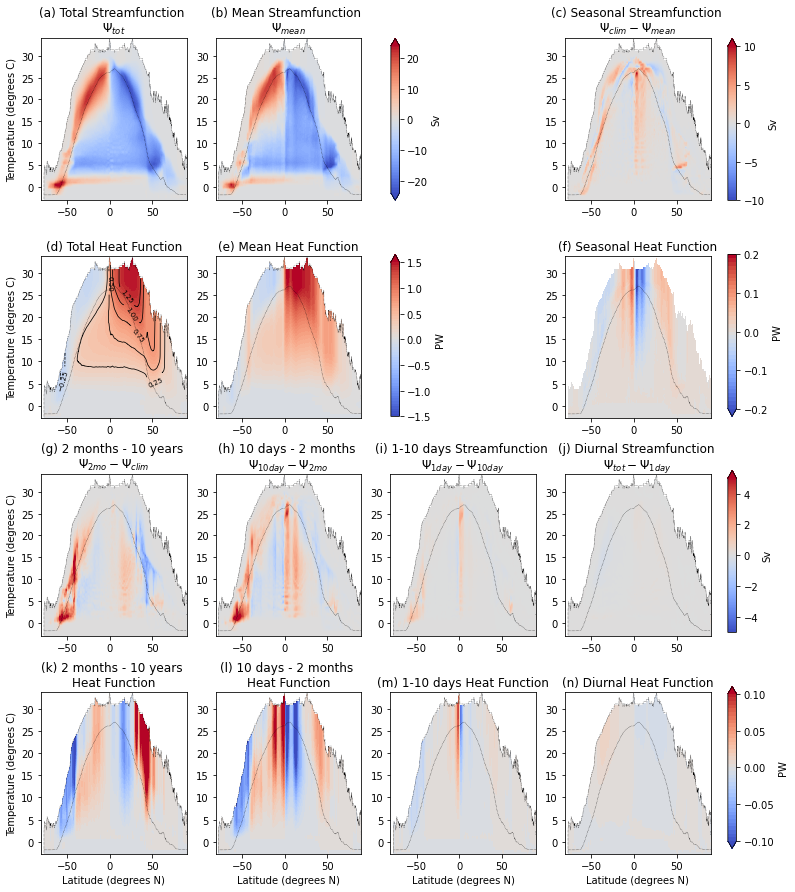

In [25]:
# Plotting:
fig = plt.figure(figsize=(12,15),facecolor='w')

Psicbar = np.arange(-24.,24.5,0.5)
Hfcbar = np.arange(-1.5,1.55,0.05)
SFcbar = np.arange(-50.,51.,1.)
MXcbar = np.arange(-25.,25.,1.)

cmap = 'coolwarm'

# Saturated bars for the seasonal/eddy terms:
sat = True
if (sat):
    Psicbar_sc = np.arange(-10.,10.1,0.1)
    Hfcbar_sc = np.arange(-0.2,0.21,0.01)
    SFcbar_sc = np.arange(-50.,51.,1.)
    MXcbar_sc = np.arange(-25.,25.,1.)
    Psicbar_e = np.arange(-5.,5.05,0.05)
    Hfcbar_e = np.arange(-0.1,0.105,0.005)
    SFcbar_e = np.arange(-5.,5.1,0.1)
    MXcbar_e = np.arange(-2.5,2.51,0.1)
else:
    Psicbar_sc = Psicbar
    Hfcbar_sc = Hfcbar
    SFcbar_sc = SFcbar
    MXcbar_sc = MXcbar
    Psicbar_e = Psicbar
    Hfcbar_e = Hfcbar
    SFcbar_e = SFcbar
    MXcbar_e = MXcbar

plt.subplot(4,4,1)
(Psi.sum('grid_xt_ocean').where(maskPsi==1.)/1.e6).plot.contourf(levels=Psicbar,x='grid_yu_ocean',add_colorbar = False,cmap=cmap)
plot_min_temp()
plot_max_temp('Psi')
plt.title('(a) Total Streamfunction \n$\Psi_{tot}$')
plt.ylabel('Temperature (degrees C)')
plt.xlabel('')

plt.subplot(4,4,2)
cb_SFrow1mean = (Psi_mean_tot.sum('grid_xt_ocean').where(maskPsi==1.)/1.e6).plot.contourf(levels=Psicbar,x='grid_yu_ocean',add_colorbar = False,cmap=cmap)
plot_min_temp()
plot_max_temp('Psi')
plt.title('(b) Mean Streamfunction \n$\Psi_{mean}$')
plt.ylabel('')
plt.xlabel('')

plt.subplot(4,4,4)
cb_SFrow1 = (Psi_ac.sum('grid_xt_ocean').where(maskPsi==1.)/1.e6).plot.contourf(levels=Psicbar_sc,x='grid_yu_ocean',add_colorbar = False,cmap=cmap)
plot_min_temp()
plot_max_temp('Psi')
plt.title('(c) Seasonal Streamfunction \n$\Psi_{clim}-\Psi_{mean}$')
plt.ylabel('')
plt.xlabel('')

plt.subplot(4,4,9)
cb_SFrow2 = (Psi_lt.sum('grid_xt_ocean').where(maskPsi==1.)/1.e6).plot.contourf(levels=Psicbar_e,x='grid_yu_ocean',add_colorbar = False,cmap=cmap)
plot_min_temp()
plot_max_temp('Psi')
plt.title('(g) 2 months - 10 years \n$\Psi_{2mo}-\Psi_{clim}$')
plt.ylabel('Temperature (degrees C)')
plt.xlabel('')

plt.subplot(4,4,10)
cb_SFrow2 =(Psi_TIWs.sum('grid_xt_ocean').where(maskPsi==1.)/1.e6).plot.contourf(levels=Psicbar_e,x='grid_yu_ocean',add_colorbar = False,cmap=cmap)
plot_min_temp()
plot_max_temp('Psi')
plt.title('(h) 10 days - 2 months \n$\Psi_{10day}-\Psi_{2mo}$')
plt.ylabel('')
plt.xlabel('')

plt.subplot(4,4,11)
(Psi_storm.sum('grid_xt_ocean').where(maskPsi==1.)/1.e6).plot.contourf(levels=Psicbar_e,x='grid_yu_ocean',add_colorbar = False,cmap=cmap)
plot_min_temp()
plot_max_temp('Psi')
plt.title('(i) 1-10 days Streamfunction \n$\Psi_{1day}-\Psi_{10day}$')
plt.ylabel('')
plt.xlabel('')

plt.subplot(4,4,12)
(Psi_diurnal.sum('grid_xt_ocean').where(maskPsi==1.)/1.e6).plot.contourf(levels=Psicbar_e,x='grid_yu_ocean',add_colorbar = False,cmap=cmap)
plot_min_temp()
plot_max_temp('Psi')
plt.title('(j) Diurnal Streamfunction \n$\Psi_{tot}-\Psi_{1day}$')
plt.ylabel('')
plt.xlabel('')


plt.subplot(4,4,5)
(Hf.sum('grid_xt_ocean').where(maskHf==1.)/1.e15).plot.contourf(levels=Hfcbar,x='grid_yu_ocean',add_colorbar = False,cmap=cmap)
CS = (Hf.sum('grid_xt_ocean').where(maskHf==1.)/1.e15).plot.contour(levels=[-1.25,-1,-0.75,-0.5,-0.25,0.25,0.5,0.75,1,1.25],x='grid_yu_ocean',colors = 'k', linewidths = 0.75)
plt.clabel(CS, fontsize=7, inline=True)

plot_min_temp()
plot_max_temp('Hf')
plt.title('(d) Total Heat Function')
plt.ylabel('Temperature (degrees C)')
plt.xlabel('')

plt.subplot(4,4,6)
cb_Hfrow1mean = (Hf_mean_tot.sum('grid_xt_ocean').where(maskHf==1.)/1.e15).plot.contourf(levels=Hfcbar,x='grid_yu_ocean',add_colorbar = False,cmap=cmap)
plot_min_temp()
plot_max_temp('Hf')
plt.title('(e) Mean Heat Function')
plt.ylabel('')
plt.xlabel('')

plt.subplot(4,4,8)
cb_Hfrow1 = (Hf_ac.sum('grid_xt_ocean').where(maskHf==1.)/1.e15).plot.contourf(levels=Hfcbar_sc,x='grid_yu_ocean',add_colorbar = False,cmap=cmap)
plot_min_temp()
plt.title('(f) Seasonal Heat Function')
plt.ylabel('')
plt.xlabel('')

plt.subplot(4,4,13)
cb_Hfrow2 = (Hf_lt.sum('grid_xt_ocean').where(maskHf==1.)/1.e15).plot.contourf(levels=Hfcbar_e,x='grid_yu_ocean',cmap=cmap, add_colorbar = False)
plot_min_temp()
plot_max_temp('Hf')
plt.title('(k) 2 months - 10 years \nHeat Function')
plt.ylabel('Temperature (degrees C)')
plt.xlabel('Latitude (degrees N)')

plt.subplot(4,4,14)
cb_Hfrow2 =(Hf_TIWs.sum('grid_xt_ocean').where(maskHf==1.)/1.e15).plot.contourf(levels=Hfcbar_e,x='grid_yu_ocean',cmap=cmap, add_colorbar = False)
plot_min_temp()
plot_max_temp('Hf')
plt.title('(l) 10 days - 2 months \nHeat Function')
plt.ylabel('')
plt.xlabel('Latitude (degrees N)')

plt.subplot(4,4,15)
(Hf_storm.sum('grid_xt_ocean').where(maskHf==1.)/1.e15).plot.contourf(levels=Hfcbar_e,x='grid_yu_ocean',cmap=cmap, add_colorbar = False)
plot_min_temp()
plot_max_temp('Hf')
plt.title('(m) 1-10 days Heat Function')
plt.ylabel('')
plt.xlabel('Latitude (degrees N)')

plt.subplot(4,4,16)
(Hf_diurnal.sum('grid_xt_ocean').where(maskHf==1.)/1.e15).plot.contourf(levels=Hfcbar_e,x='grid_yu_ocean',cmap=cmap, add_colorbar = False)
plot_min_temp()
plot_max_temp('Hf')
plt.title('(n) Diurnal Heat Function')
plt.ylabel('')
plt.xlabel('Latitude (degrees N)')

fig.subplots_adjust(wspace = 0.2, hspace = 0.35, right = 0.9)

ax_cb = plt.axes([0.53,0.73,0.01,0.15])
plt.colorbar(cb_SFrow1mean, cax = ax_cb, label = 'Sv', ticks = np.arange(-20,21,10))


ax_cb = plt.axes([0.53,0.53,0.01,0.15])
plt.colorbar(cb_Hfrow1mean, cax = ax_cb, label = 'PW', ticks = np.arange(-1.5,1.55,0.5))


ax_cb = plt.axes([0.92,0.73,0.01,0.15])
plt.colorbar(cb_SFrow1, cax = ax_cb, label = 'Sv', ticks = np.arange(-10,10.05,5))


ax_cb = plt.axes([0.92,0.53,0.01,0.15])
plt.colorbar(cb_Hfrow1, cax = ax_cb, label = 'PW', ticks = np.arange(-0.2,0.21,0.1))


ax_cb = plt.axes([0.92,0.33,0.01,0.15])
plt.colorbar(cb_SFrow2, cax = ax_cb, label = 'Sv', ticks = np.arange(-4,4.05,2))


ax_cb = plt.axes([0.92,0.13,0.01,0.15])
plt.colorbar(cb_Hfrow2, cax = ax_cb, label = 'PW', ticks = np.arange(-0.1,0.11,0.05))


#plt.tight_layout()
plt.savefig('Decomposition_stream_and_heat_func_sat.png',dpi = 200)

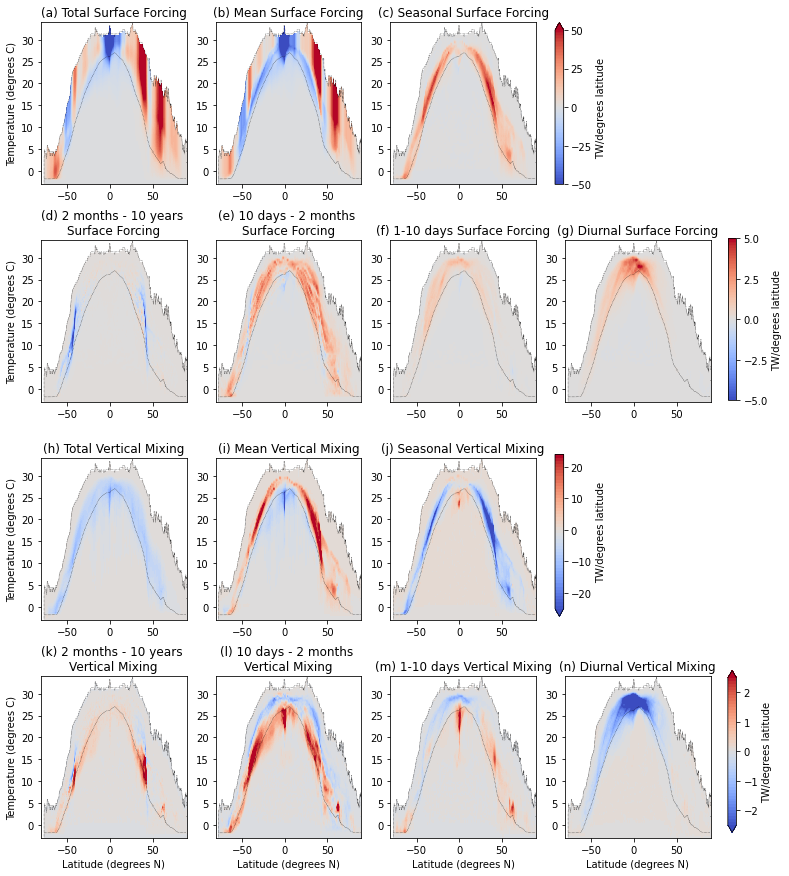

In [26]:
# Plotting:
fig = plt.figure(figsize=(12,15),facecolor='w')

Psicbar = np.arange(-24.,24.5,0.5)
Hfcbar = np.arange(-1.,1.05,0.05)
SFcbar = np.arange(-50.,51.,1.)
MXcbar = np.arange(-25.,25.,1.)

cmap = 'coolwarm'

# Saturated bars for the seasonal/eddy terms:
sat = True
if (sat):
    Psicbar_sc = np.arange(-10.,10.1,0.1)
    Hfcbar_sc = np.arange(-0.2,0.21,0.01)
    SFcbar_sc = np.arange(-50.,51.,1.)
    MXcbar_sc = np.arange(-25.,25.,1.)
    Psicbar_e = np.arange(-5.,5.1,0.05)
    Hfcbar_e = np.arange(-0.1,0.105,0.005)
    SFcbar_e = np.arange(-5.,5.1,0.1)
    MXcbar_e = np.arange(-2.5,2.51,0.1)
else:
    Psicbar_sc = Psicbar
    Hfcbar_sc = Hfcbar
    SFcbar_sc = SFcbar
    MXcbar_sc = MXcbar
    Psicbar_e = Psicbar
    Hfcbar_e = Hfcbar
    SFcbar_e = SFcbar
    MXcbar_e = MXcbar

plt.subplot(4,4,1)
(SF.sum('grid_xt_ocean').where(maskSF==1.)/1.e12/dy).plot.contourf(levels=SFcbar,x='grid_yt_ocean',add_colorbar = False,cmap=cmap)
plot_min_temp()
plot_max_temp('SF')
plt.title('(a) Total Surface Forcing')
plt.ylabel('Temperature (degrees C)')
plt.xlabel('')

plt.subplot(4,4,2)
cb_SFrow1mean = (SF_mean_tot.sum('grid_xt_ocean').where(maskSF==1.)/1.e12/dy).plot.contourf(levels=SFcbar,x='grid_yt_ocean',add_colorbar = False,cmap=cmap)
plot_min_temp()
plot_max_temp('SF')
plt.title('(b) Mean Surface Forcing')
plt.ylabel('')
plt.xlabel('')

plt.subplot(4,4,3)
cb_SFrow1 = (SF_ac.sum('grid_xt_ocean').where(maskSF==1.)/1.e12/dy).plot.contourf(levels=SFcbar,x='grid_yt_ocean',add_colorbar = False,cmap=cmap)
plot_min_temp()
plot_max_temp('SF')
plt.title('(c) Seasonal Surface Forcing')
plt.ylabel('')
plt.xlabel('')

plt.subplot(4,4,5)
cb_SFrow2 = (SF_lt.sum('grid_xt_ocean').where(maskSF==1.)/1.e12/dy).plot.contourf(levels=SFcbar_e,x='grid_yt_ocean',add_colorbar = False,cmap=cmap)
plot_min_temp()
plot_max_temp('SF')
plt.title('(d) 2 months - 10 years \nSurface Forcing')
plt.ylabel('Temperature (degrees C)')
plt.xlabel('')

plt.subplot(4,4,6)
cb_SFrow2 =(SF_TIWs.sum('grid_xt_ocean').where(maskSF==1.)/1.e12/dy).plot.contourf(levels=SFcbar_e,x='grid_yt_ocean',add_colorbar = False,cmap=cmap)
plot_min_temp()
plot_max_temp('SF')
plt.title('(e) 10 days - 2 months \nSurface Forcing')
plt.ylabel('')
plt.xlabel('')

plt.subplot(4,4,7)
(SF_storm.sum('grid_xt_ocean').where(maskSF==1.)/1.e12/dy).plot.contourf(levels=SFcbar_e,x='grid_yt_ocean',add_colorbar = False,cmap=cmap)
plot_min_temp()
plot_max_temp('SF')
plt.title('(f) 1-10 days Surface Forcing')
plt.ylabel('')
plt.xlabel('')

plt.subplot(4,4,8)
(SF_diurnal.sum('grid_xt_ocean').where(maskSF==1.)/1.e12/dy).plot.contourf(levels=SFcbar_e,x='grid_yt_ocean',add_colorbar = False,cmap=cmap)
plot_min_temp()
plot_max_temp('SF')
plt.title('(g) Diurnal Surface Forcing')
plt.ylabel('')
plt.xlabel('')


plt.subplot(4,4,9)
(MX.sum('grid_xt_ocean').where(maskSF==1.)/1.e12/dy).plot.contourf(levels=MXcbar,x='grid_yt_ocean',add_colorbar = False,cmap=cmap)
plot_min_temp()
plot_max_temp('SF')
plt.title('(h) Total Vertical Mixing')
plt.ylabel('Temperature (degrees C)')
plt.xlabel('')

plt.subplot(4,4,10)
cb_MXrow1mean = (MX_mean_tot.sum('grid_xt_ocean').where(maskSF==1.)/1.e12/dy).plot.contourf(levels=MXcbar,x='grid_yt_ocean',add_colorbar = False,cmap=cmap)
plot_min_temp()
plot_max_temp('SF')
plt.title('(i) Mean Vertical Mixing')
plt.ylabel('')
plt.xlabel('')

plt.subplot(4,4,11)
cb_MXrow1 = (MX_ac.sum('grid_xt_ocean').where(maskSF==1.)/1.e12/dy).plot.contourf(levels=MXcbar,x='grid_yt_ocean',add_colorbar = False,cmap=cmap)
plot_min_temp()
plot_max_temp('SF')
plt.title('(j) Seasonal Vertical Mixing')
plt.ylabel('')
plt.xlabel('')

plt.subplot(4,4,13)
cb_MXrow2 = (MX_lt.sum('grid_xt_ocean').where(maskSF==1.)/1.e12/dy).plot.contourf(levels=MXcbar_e,x='grid_yt_ocean',add_colorbar = False,cmap=cmap)
plot_min_temp()
plot_max_temp('SF')
plt.title('(k) 2 months - 10 years \nVertical Mixing')
plt.ylabel('Temperature (degrees C)')
plt.xlabel('Latitude (degrees N)')

plt.subplot(4,4,14)
cb_MXrow2 =(MX_TIWs.sum('grid_xt_ocean').where(maskSF==1.)/1.e12/dy).plot.contourf(levels=MXcbar_e,x='grid_yt_ocean',add_colorbar = False,cmap=cmap)
plot_min_temp()
plot_max_temp('SF')
plt.title('(l) 10 days - 2 months \nVertical Mixing')
plt.ylabel('')
plt.xlabel('Latitude (degrees N)')

plt.subplot(4,4,15)
(MX_storm.sum('grid_xt_ocean').where(maskSF==1.)/1.e12/dy).plot.contourf(levels=MXcbar_e,x='grid_yt_ocean',add_colorbar = False,cmap=cmap)
plot_min_temp()
plot_max_temp('SF')
plt.title('(m) 1-10 days Vertical Mixing')
plt.ylabel('')
plt.xlabel('Latitude (degrees N)')

plt.subplot(4,4,16)
(MX_diurnal.sum('grid_xt_ocean').where(maskSF==1.)/1.e12/dy).plot.contourf(levels=MXcbar_e,x='grid_yt_ocean',add_colorbar = False,cmap=cmap)
plot_min_temp()
plot_max_temp('SF')
plt.title('(n) Diurnal Vertical Mixing')
plt.ylabel('')
plt.xlabel('Latitude (degrees N)')

fig.subplots_adjust(wspace = 0.2, hspace = 0.35, right = 0.9)

ax_cb = plt.axes([0.72,0.73,0.01,0.15])
plt.colorbar(cb_SFrow1, cax = ax_cb, label = 'TW/degrees latitude', ticks = np.arange(-50,51,25))

ax_cb = plt.axes([0.92,0.53,0.01,0.15])
plt.colorbar(cb_SFrow2, cax = ax_cb, label = 'TW/degrees latitude', ticks = np.arange(-5,5.1,2.5))

ax_cb = plt.axes([0.72,0.33,0.01,0.15])
plt.colorbar(cb_MXrow1, cax = ax_cb, label = 'TW/degrees latitude', ticks = np.arange(-20,20.1,10))

ax_cb = plt.axes([0.92,0.13,0.01,0.15])
plt.colorbar(cb_MXrow2, cax = ax_cb, label = 'TW/degrees latitude', ticks = np.arange(-2.,2.1,1.))


#plt.tight_layout()
plt.savefig('Decomposition_SF_mixing_sat.png',dpi = 200)

## MHT DHT 1D Split into 4 panels

In [15]:
cmdict = cm.tools.get_dict(cm.cm.thermal, N=9)

#color = (cmdict['red'][j+4][1],cmdict['green'][j+4][1],cmdict['blue'][j][1])

In [16]:
c0 = 'k'#(cmdict['red'][8][1],cmdict['green'][8][1],cmdict['blue'][8][1])#'k'
c1 = 'C0'#(cmdict['red'][7][1],cmdict['green'][7][1],cmdict['blue'][7][1])#'blue'
c2 = 'C1'#(cmdict['red'][6][1],cmdict['green'][6][1],cmdict['blue'][6][1])#'royalblue'
c3 = 'navy'#(cmdict['red'][5][1],cmdict['green'][5][1],cmdict['blue'][5][1])#'darkviolet'
c4 = 'C2'#(cmdict['red'][4][1],cmdict['green'][4][1],cmdict['blue'][4][1])#'palevioletred'
c5 = 'C4'#(cmdict['red'][3][1],cmdict['green'][3][1],cmdict['blue'][3][1])#'salmon'
c6 = 'C5'#(cmdict['red'][2][1],cmdict['green'][2][1],cmdict['blue'][2][1])#'orange'

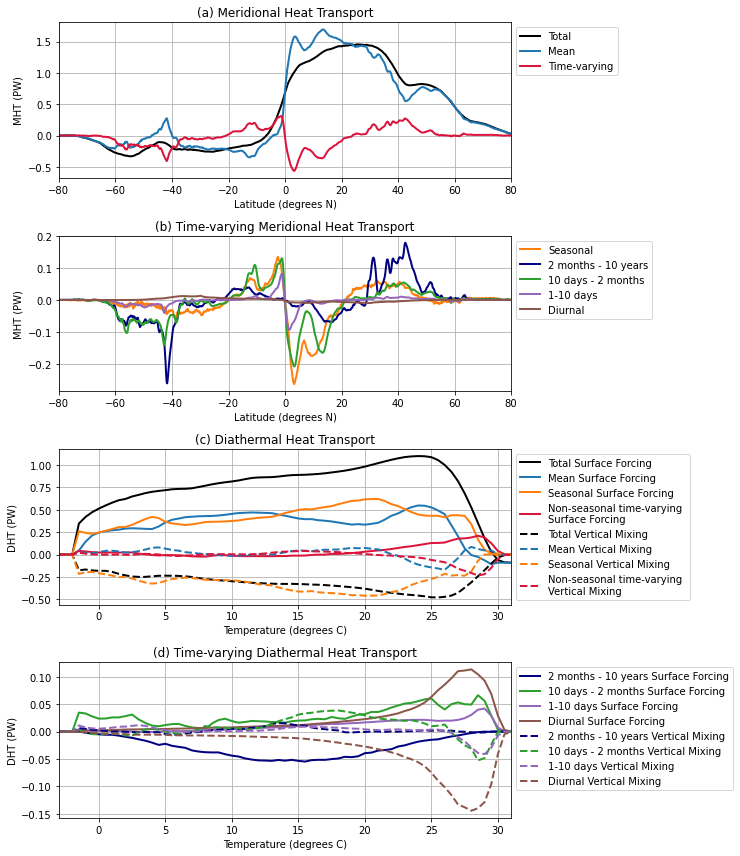

In [27]:
plt.figure(figsize=(11,12))

plt.subplot(4,1,1)
(Hf.sum('grid_xt_ocean')/1.e15).isel(neutral=-1).plot(color = c0,label='Total',linewidth=2)
(Hf_mean_tot.sum('grid_xt_ocean')/1.e15).isel(neutral=-1).plot(color = c1,label='Mean',linewidth=2)
((Hf_ac+Hf_lt+Hf_TIWs+Hf_storm+Hf_diurnal).sum('grid_xt_ocean')/1.e15).isel(neutral=-1).plot(color = 'crimson',label='Time-varying',linewidth=2)
#(Hf_lt.sum('grid_xt_ocean')/1.e15).isel(neutral=-1).plot(color = c3,label='> 2 months',linewidth=2)
#(Hf_TIWs.sum('grid_xt_ocean')/1.e15).isel(neutral=-1).plot(color = c4,label='10 days - 2 months',linewidth=2)
#(Hf_storm.sum('grid_xt_ocean')/1.e15).isel(neutral=-1).plot(color = c5,label='1-10 days',linewidth=2)
#(Hf_diurnal.sum('grid_xt_ocean')/1.e15).isel(neutral=-1).plot(color = c6,label='Diurnal',linewidth=2)

plt.legend(bbox_to_anchor = (1,1),loc='upper left')
plt.ylabel('MHT (PW)')
plt.xlabel('Latitude (degrees N)')
plt.title('(a) Meridional Heat Transport')
plt.grid()
plt.xlim([-80.,80.])
 
plt.subplot(4,1,2)
#(Hf.sum('grid_xt_ocean')/1.e15).isel(neutral=-1).plot(color = c0,label='Total',linewidth=2)
#(Hf_mean_tot.sum('grid_xt_ocean')/1.e15).isel(neutral=-1).plot(color = c1,label='Mean',linewidth=2)
(Hf_ac.sum('grid_xt_ocean')/1.e15).isel(neutral=-1).plot(color = c2,label='Seasonal',linewidth=2)
(Hf_lt.sum('grid_xt_ocean')/1.e15).isel(neutral=-1).plot(color = c3,label='2 months - 10 years',linewidth=2)
(Hf_TIWs.sum('grid_xt_ocean')/1.e15).isel(neutral=-1).plot(color = c4,label='10 days - 2 months',linewidth=2)
(Hf_storm.sum('grid_xt_ocean')/1.e15).isel(neutral=-1).plot(color = c5,label='1-10 days',linewidth=2)
(Hf_diurnal.sum('grid_xt_ocean')/1.e15).isel(neutral=-1).plot(color = c6,label='Diurnal',linewidth=2)

plt.legend(bbox_to_anchor = (1,1),loc='upper left')
plt.ylabel('MHT (PW)')
plt.xlabel('Latitude (degrees N)')
plt.title('(b) Time-varying Meridional Heat Transport')
plt.grid()
plt.xlim([-80.,80.])


plt.subplot(4,1,3)
(SF.sum('grid_xt_ocean')/1.e15).sum('grid_yt_ocean').plot(label='Total Surface Forcing',color=c0,linewidth=2)
(SF_mean_tot.sum('grid_xt_ocean')/1.e15).sum('grid_yt_ocean').plot(label='Mean Surface Forcing',color=c1,linewidth=2)
(SF_ac.sum('grid_xt_ocean')/1.e15).sum('grid_yt_ocean').plot(label='Seasonal Surface Forcing',color=c2,linewidth=2)
((SF_lt+SF_TIWs+SF_storm+SF_diurnal).sum('grid_xt_ocean')/1.e15).sum('grid_yt_ocean').plot(label='Non-seasonal time-varying \nSurface Forcing',color='crimson',linewidth=2)
#(SF_TIWs.sum('grid_xt_ocean')/1.e15).sum('grid_yt_ocean').plot(label='10 days - 2 months Surface Forcing',color=c4,linewidth=2)
#(SF_storm.sum('grid_xt_ocean')/1.e15).sum('grid_yt_ocean').plot(label='1-10 days Surface Forcing',color=c5,linewidth=2)
#(SF_diurnal.sum('grid_xt_ocean')/1.e15).sum('grid_yt_ocean').plot(label='Diurnal Surface Forcing',color=c6,linewidth=2)


(MX.sum('grid_xt_ocean')/1.e15).sum('grid_yt_ocean').plot(label='Total Vertical Mixing',color=c0,linestyle='dashed',linewidth=2)
(MX_mean_tot.sum('grid_xt_ocean')/1.e15).sum('grid_yt_ocean').plot(label='Mean Vertical Mixing',color=c1,linestyle='dashed',linewidth=2)
(MX_ac.sum('grid_xt_ocean')/1.e15).sum('grid_yt_ocean').plot(label='Seasonal Vertical Mixing',color=c2,linestyle='dashed',linewidth=2)
((MX_lt+MX_TIWs+MX_storm+MX_diurnal).sum('grid_xt_ocean')/1.e15).sum('grid_yt_ocean').plot(label='Non-seasonal time-varying \nVertical Mixing',color='crimson',linestyle='dashed',linewidth=2)
#(MX_TIWs.sum('grid_xt_ocean')/1.e15).sum('grid_yt_ocean').plot(label='10 days - 2 months Vertical Mixing',color=c4,linestyle='dashed',linewidth=2)
#(MX_storm.sum('grid_xt_ocean')/1.e15).sum('grid_yt_ocean').plot(label='1-10 days Vertical Mixing',color=c5,linestyle='dashed',linewidth=2)
#(MX_diurnal.sum('grid_xt_ocean')/1.e15).sum('grid_yt_ocean').plot(label='Diurnal Vertical Mixing',color=c6,linestyle='dashed',linewidth=2)

plt.legend(bbox_to_anchor = (1,1),loc='upper left')
plt.ylabel('DHT (PW)')
plt.xlabel('Temperature (degrees C)')
plt.title('(c) Diathermal Heat Transport')
plt.grid()
plt.xlim([-3.,31.])

plt.subplot(4,1,4)
# (SF.sum('grid_xt_ocean')/1.e15).sum('grid_yt_ocean').plot(label='Total Surface Forcing',color=c0,linewidth=2)
# (SF_mean_tot.sum('grid_xt_ocean')/1.e15).sum('grid_yt_ocean').plot(label='Mean Surface Forcing',color=c1,linewidth=2)
# (SF_ac.sum('grid_xt_ocean')/1.e15).sum('grid_yt_ocean').plot(label='Seasonal Surface Forcing',color=c2,linewidth=2)
(SF_lt.sum('grid_xt_ocean')/1.e15).sum('grid_yt_ocean').plot(label='2 months - 10 years Surface Forcing',color=c3,linewidth=2)
(SF_TIWs.sum('grid_xt_ocean')/1.e15).sum('grid_yt_ocean').plot(label='10 days - 2 months Surface Forcing',color=c4,linewidth=2)
(SF_storm.sum('grid_xt_ocean')/1.e15).sum('grid_yt_ocean').plot(label='1-10 days Surface Forcing',color=c5,linewidth=2)
(SF_diurnal.sum('grid_xt_ocean')/1.e15).sum('grid_yt_ocean').plot(label='Diurnal Surface Forcing',color=c6,linewidth=2)


# (MX.sum('grid_xt_ocean')/1.e15).sum('grid_yt_ocean').plot(label='Total Vertical Mixing',color=c0,linestyle='dashed',linewidth=2)
# (MX_mean_tot.sum('grid_xt_ocean')/1.e15).sum('grid_yt_ocean').plot(label='Mean Vertical Mixing',color=c1,linestyle='dashed',linewidth=2)
# (MX_ac.sum('grid_xt_ocean')/1.e15).sum('grid_yt_ocean').plot(label='Seasonal Vertical Mixing',color=c2,linestyle='dashed',linewidth=2)
(MX_lt.sum('grid_xt_ocean')/1.e15).sum('grid_yt_ocean').plot(label='2 months - 10 years Vertical Mixing',color=c3,linestyle='dashed',linewidth=2)
(MX_TIWs.sum('grid_xt_ocean')/1.e15).sum('grid_yt_ocean').plot(label='10 days - 2 months Vertical Mixing',color=c4,linestyle='dashed',linewidth=2)
(MX_storm.sum('grid_xt_ocean')/1.e15).sum('grid_yt_ocean').plot(label='1-10 days Vertical Mixing',color=c5,linestyle='dashed',linewidth=2)
(MX_diurnal.sum('grid_xt_ocean')/1.e15).sum('grid_yt_ocean').plot(label='Diurnal Vertical Mixing',color=c6,linestyle='dashed',linewidth=2)

plt.legend(bbox_to_anchor = (1,1),loc='upper left')
plt.ylabel('DHT (PW)')
plt.xlabel('Temperature (degrees C)')
plt.title('(d) Time-varying Diathermal Heat Transport')
plt.grid()
plt.xlim([-3.,31.])


plt.tight_layout()
plt.subplots_adjust(right = 0.65)
plt.savefig('MHT_DHT_7timescales_4panels.png',dpi = 200,pad_inches=3)

## lat-lon maps

In [21]:
# Group mean SF and MX terms:
fwmass_mean["SF_cv"] = fwmass_mean.temp_vdiffuse_sbc_on_nrho + \
                       fwmass_mean.sfc_hflux_pme_on_nrho + \
                       fwmass_mean.frazil_on_nrho + \
                       fwmass_mean.sw_heat_on_nrho #+ \
                       #fwmass_mean.temp_rivermix_on_nrho
fwmass_mean["MX_cv"] = fwmass_mean.temp_vdiffuse_diff_cbt_on_nrho + \
                       fwmass_mean.temp_nonlocal_KPP_on_nrho 

obj, obj2 = xr.broadcast(fheat_mean.sfc_hflux_pme,fheat_mean.temp_vdiffuse_sbc)
sfc_hflux_pme_mean = obj.where(fheat_mean.st_ocean==fheat_mean.st_ocean[0],other=0.)

fheat_mean["SF_cv"] = fheat_mean.temp_vdiffuse_sbc + \
                      sfc_hflux_pme_mean + \
                      fheat_mean.frazil_3d + \
                      fheat_mean.sw_heat # + \
#                      fheat_mean.temp_rivermix
fheat_mean["MX_cv"] = fheat_mean.temp_vdiffuse_diff_cbt + \
                      fheat_mean.temp_nonlocal_KPP


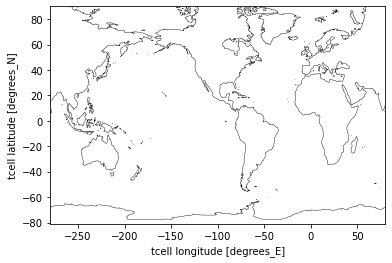

In [22]:
mask = (fgrd.ht.where(fgrd.ht>0)*0+1).fillna(0)
mask.plot.contour(levels = [0.5],linewidths = 0.4, colors = 'k')

In [23]:
dT

array(0.5)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


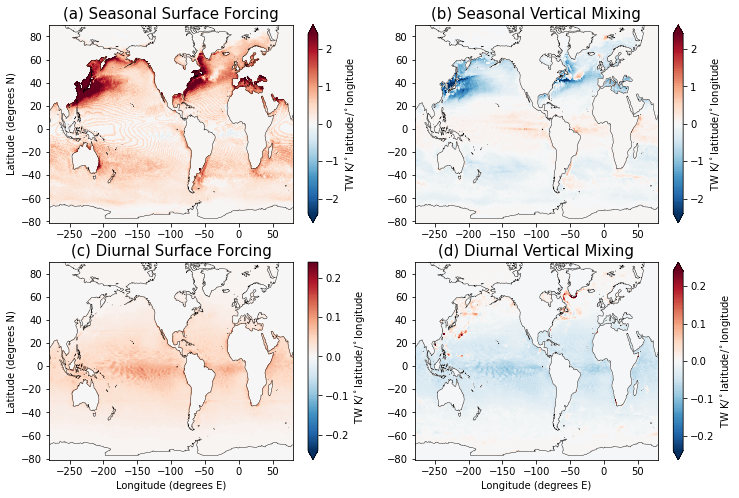

In [28]:
plt.figure(figsize=(12,8),facecolor='w')
cmap = 'RdBu_r'

## Plot data from Seasonal Term
DataSet = sc_Twomo_mean_10year_means - Mean_10year_means

SFcbar = np.arange(-2.4,2.45,0.05)
MXcbar = np.arange(-2.4,2.45,0.05)

plt.subplot(2,2,1)
(DataSet.SF.sum('neutralrho_edges')/1.e12/dx/dy*dT).plot.contourf(levels=SFcbar,y='grid_yt_ocean',cbar_kwargs={'label':'TW K/$^\circ$latitude/$^\circ$longitude','ticks':np.arange(-2.,2.1,1)},cmap=cmap)
mask.plot.contour(levels = [0.5],linewidths = 0.4, colors = 'k')
plt.title('(a) Seasonal Surface Forcing', fontsize = 15)
plt.ylabel('Latitude (degrees N)')
plt.xlabel('')

plt.subplot(2,2,2)
(DataSet.MX.sum('neutralrho_edges')/1.e12/dx/dy*dT).plot.contourf(levels=MXcbar,y='grid_yt_ocean',cbar_kwargs={'label':'TW K/$^\circ$latitude/$^\circ$longitude','ticks':np.arange(-2.,2.1,1)},cmap=cmap)
mask.plot.contour(levels = [0.5],linewidths = 0.4, colors = 'k')
plt.title('(b) Seasonal Vertical Mixing', fontsize = 15)
plt.ylabel('')
plt.xlabel('')

## Plot data from Diurnal Term
DataSet = True_10year_means - Oneday_mean_10year_means 

SFcbar = np.arange(-0.24,0.245,0.005)
MXcbar = np.arange(-0.24,0.245,0.005)

plt.subplot(2,2,3)
(DataSet.SF.sum('neutralrho_edges')/1.e12/dx/dy*dT).plot.contourf(levels=SFcbar,y='grid_yt_ocean',cbar_kwargs={'label':'TW K/$^\circ$latitude/$^\circ$longitude','ticks':np.arange(-0.2,0.21,0.1)},cmap=cmap)
mask.plot.contour(levels = [0.5],linewidths = 0.4, colors = 'k')
plt.title('(c) Diurnal Surface Forcing', fontsize = 15)
plt.ylabel('Latitude (degrees N)')
plt.xlabel('Longitude (degrees E)')


plt.subplot(2,2,4)
(DataSet.MX.sum('neutralrho_edges')/1.e12/dx/dy*dT).plot.contourf(levels=MXcbar,y='grid_yt_ocean',cbar_kwargs={'label':'TW K/$^\circ$latitude/$^\circ$longitude','ticks':np.arange(-0.2,0.21,0.1)},cmap=cmap)
mask.plot.contour(levels = [0.5],linewidths = 0.4, colors = 'k')
plt.title('(d) Diurnal Vertical Mixing', fontsize = 15)
plt.ylabel('')
plt.xlabel('Longitude (degrees E)')


plt.savefig('Maps_seasonal_and_diurnal.png',dpi = 200)

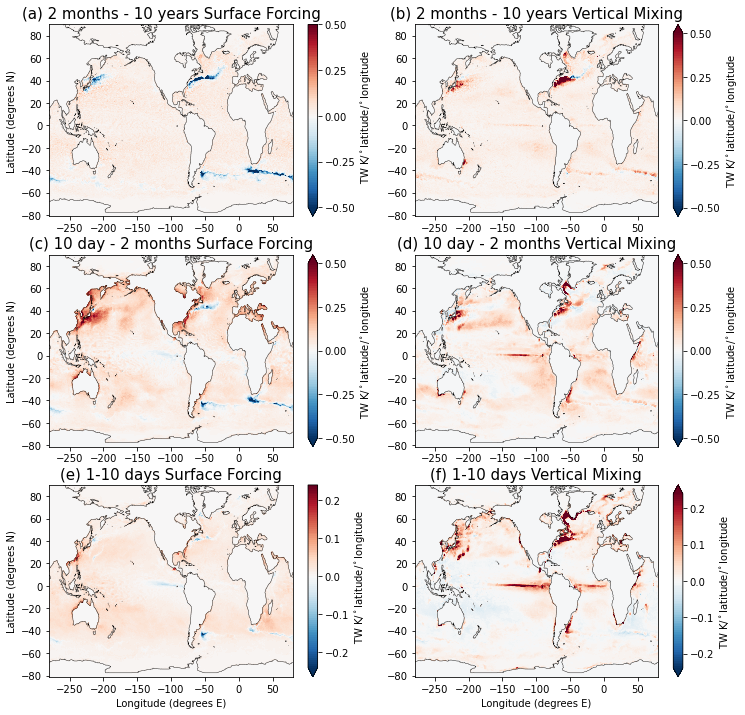

In [29]:
plt.figure(figsize=(12,12),facecolor='w')
cmap = 'RdBu_r'

## Plot data from lt
DataSet = Twomo_mean_10year_means - sc_Twomo_mean_10year_means

SFcbar =  np.arange(-0.5,0.51,0.01)
MXcbar =  np.arange(-0.5,0.51,0.01)

plt.subplot(3,2,1)
(DataSet.SF.sum('neutralrho_edges')/1.e12/dx/dy*dT).plot.contourf(levels=SFcbar,y='grid_yt_ocean',cbar_kwargs={'label':'TW K/$^\circ$latitude/$^\circ$longitude','ticks':np.arange(-0.5,0.51,0.25)},cmap=cmap)
mask.plot.contour(levels = [0.5],linewidths = 0.4, colors = 'k')
plt.title('(a) 2 months - 10 years Surface Forcing', fontsize = 15)
plt.ylabel('Latitude (degrees N)')
plt.xlabel('')

plt.subplot(3,2,2)
(DataSet.MX.sum('neutralrho_edges')/1.e12/dx/dy*dT).plot.contourf(levels=MXcbar,y='grid_yt_ocean',cbar_kwargs={'label':'TW K/$^\circ$latitude/$^\circ$longitude','ticks':np.arange(-0.5,0.51,0.25)},cmap=cmap)
mask.plot.contour(levels = [0.5],linewidths = 0.4, colors = 'k')
plt.title('(b) 2 months - 10 years Vertical Mixing', fontsize = 15)
plt.ylabel('')
plt.xlabel('')

## Plot data from 10day-2 months Term
DataSet = Tenday_mean_10year_means - Twomo_mean_10year_means 

SFcbar =  np.arange(-0.5,0.51,0.01)
MXcbar =  np.arange(-0.5,0.51,0.01)

plt.subplot(3,2,3)
(DataSet.SF.sum('neutralrho_edges')/1.e12/dx/dy*dT).plot.contourf(levels=SFcbar,y='grid_yt_ocean',cbar_kwargs={'label':'TW K/$^\circ$latitude/$^\circ$longitude','ticks':np.arange(-0.5,0.51,0.25)},cmap=cmap)
mask.plot.contour(levels = [0.5],linewidths = 0.4, colors = 'k')
plt.title('(c) 10 day - 2 months Surface Forcing', fontsize = 15)
plt.ylabel('Latitude (degrees N)')
plt.xlabel('')


plt.subplot(3,2,4)
(DataSet.MX.sum('neutralrho_edges')/1.e12/dx/dy*dT).plot.contourf(levels=MXcbar,y='grid_yt_ocean',cbar_kwargs={'label':'TW K/$^\circ$latitude/$^\circ$longitude','ticks':np.arange(-0.5,0.51,0.25)},cmap=cmap)
mask.plot.contour(levels = [0.5],linewidths = 0.4, colors = 'k')
plt.title('(d) 10 day - 2 months Vertical Mixing', fontsize = 15)
plt.ylabel('')
plt.xlabel('')

## Plot data from Storm Term
DataSet = Oneday_mean_10year_means - Tenday_mean_10year_means 

SFcbar = np.arange(-0.24,0.245,0.005)
MXcbar = np.arange(-0.24,0.245,0.005)

plt.subplot(3,2,5)
(DataSet.SF.sum('neutralrho_edges')/1.e12/dx/dy*dT).plot.contourf(levels=SFcbar,y='grid_yt_ocean',cbar_kwargs={'label':'TW K/$^\circ$latitude/$^\circ$longitude','ticks':np.arange(-0.2,0.21,0.1)},cmap=cmap)
mask.plot.contour(levels = [0.5],linewidths = 0.4, colors = 'k')
plt.title('(e) 1-10 days Surface Forcing', fontsize = 15)
plt.ylabel('Latitude (degrees N)')
plt.xlabel('Longitude (degrees E)')


plt.subplot(3,2,6)
(DataSet.MX.sum('neutralrho_edges')/1.e12/dx/dy*dT).plot.contourf(levels=MXcbar,y='grid_yt_ocean',cbar_kwargs={'label':'TW K/$^\circ$latitude/$^\circ$longitude','ticks':np.arange(-0.2,0.21,0.1)},cmap=cmap)
mask.plot.contour(levels = [0.5],linewidths = 0.4, colors = 'k')
plt.title('(f) 1-10 days Vertical Mixing', fontsize = 15)
plt.ylabel('')
plt.xlabel('Longitude (degrees E)')


plt.savefig('Maps_lt_eddy_storm.png',dpi = 200)

# Separation into different mixing terms

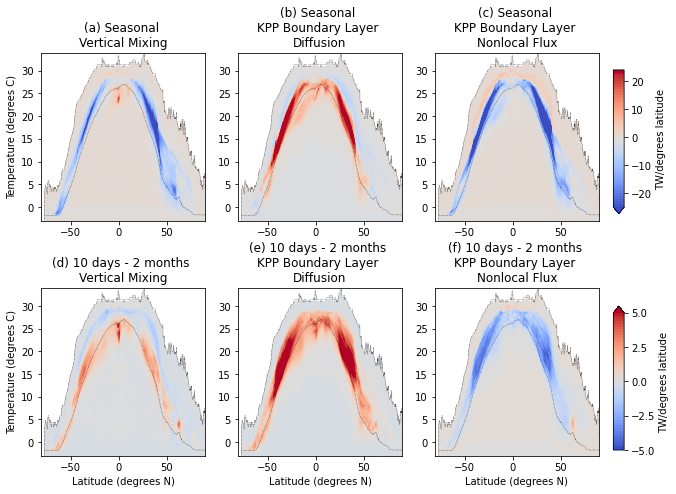

In [31]:
# masking:
maskPsi = 0*True_10year_means.Psi.sum('grid_xt_ocean').where(True_10year_means.Psi.sum('grid_xt_ocean')!=True_10year_means.Psi.sum('grid_xt_ocean').isel(neutralrho_edges=-1))+1.
maskHf = gridwm.interp(maskPsi,'T')
maskSF = gridwm.interp(maskPsi,'y',boundary="fill",fill_value=0.)
maskSF

Psicbar = np.arange(-24.,24.5,0.5)
Hfcbar = np.arange(-1.,1.05,0.05)
SFcbar = np.arange(-50.,51.,1.)
MXcbar = np.arange(-25.,25.,1.)


plt.figure(figsize=(10,8),facecolor='w')
cmap = 'coolwarm'
    
plt.subplot(2,3,1)
DataSet =  sc_Twomo_mean_10year_means - Mean_10year_means
MXcbar = np.arange(-25.,25.,1.)
cbar1  = (DataSet.MX.sum('grid_xt_ocean').where(maskSF==1.)/1.e12/dy).plot.contourf(levels=MXcbar,x='grid_yt_ocean',add_colorbar = False,cmap=cmap)
plot_min_temp()
plot_max_temp('SF')
plt.title('(a) Seasonal \nVertical Mixing')
plt.ylabel('Temperature (degrees C)')
plt.xlabel('')

plt.subplot(2,3,2)
(DataSet.temp_vdiffuse_diff_cbt_kppbl.sum('grid_xt_ocean').where(maskSF==1.)/1.e12/dy).plot.contourf(levels=MXcbar,x='grid_yt_ocean',add_colorbar = False,cmap=cmap)
plot_min_temp()
plot_max_temp('SF')
plt.title('(b) Seasonal \nKPP Boundary Layer \nDiffusion')
plt.ylabel('')
plt.xlabel('')

plt.subplot(2,3,3)
temp = DataSet.MX-DataSet.temp_vdiffuse_diff_cbt_wave-DataSet.temp_vdiffuse_diff_cbt_kppdd - \
       DataSet.temp_vdiffuse_diff_cbt_kppbl - DataSet.temp_vdiffuse_diff_cbt_kppicon - \
       DataSet.temp_vdiffuse_diff_cbt_kppish

(temp.sum('grid_xt_ocean').where(maskSF==1.)/1.e12/dy).plot.contourf(levels=MXcbar,x='grid_yt_ocean',add_colorbar = False,cmap=cmap)
plot_min_temp()
plot_max_temp('SF')
plt.title('(c) Seasonal \nKPP Boundary Layer \nNonlocal Flux')
plt.ylabel('')
plt.xlabel('')

ax_cb = plt.axes([0.92,0.52,0.015,0.25])
plt.colorbar(cbar1, cax = ax_cb, label = 'TW/degrees latitude',ticks = np.arange(-20.,20.1,10))

MXcbar = np.arange(-25.,25.1,1.)/5

plt.subplot(2,3,4)
DataSet = Tenday_mean_10year_means - Twomo_mean_10year_means 
cbar1  = (DataSet.MX.sum('grid_xt_ocean').where(maskSF==1.)/1.e12/dy).plot.contourf(levels=MXcbar,x='grid_yt_ocean',add_colorbar = False,cmap=cmap)
plot_min_temp()
plot_max_temp('SF')
plt.title('(d) 10 days - 2 months \nVertical Mixing')
plt.ylabel('Temperature (degrees C)')
plt.xlabel('Latitude (degrees N)')

plt.subplot(2,3,5)
(DataSet.temp_vdiffuse_diff_cbt_kppbl.sum('grid_xt_ocean').where(maskSF==1.)/1.e12/dy).plot.contourf(levels=MXcbar,x='grid_yt_ocean',add_colorbar = False,cmap=cmap)
plot_min_temp()
plot_max_temp('SF')
plt.title('(e) 10 days - 2 months \nKPP Boundary Layer \nDiffusion')
plt.ylabel('')
plt.xlabel('Latitude (degrees N)')

plt.subplot(2,3,6)
a = Tenday_mean_10year_means.temp_nonlocal_KPP
DataSet = Twomo_mean_10year_means 
b = DataSet.MX-DataSet.temp_vdiffuse_diff_cbt_wave-DataSet.temp_vdiffuse_diff_cbt_kppdd - \
       DataSet.temp_vdiffuse_diff_cbt_kppbl - DataSet.temp_vdiffuse_diff_cbt_kppicon - \
       DataSet.temp_vdiffuse_diff_cbt_kppish
((a-b).sum('grid_xt_ocean').where(maskSF==1.)/1.e12/dy).plot.contourf(levels=MXcbar,x='grid_yt_ocean',add_colorbar = False,cmap=cmap)
plot_min_temp()
plot_max_temp('SF')
plt.title('(f) 10 days - 2 months \nKPP Boundary Layer \nNonlocal Flux')
plt.ylabel('')
plt.xlabel('Latitude (degrees N)')

ax_cb = plt.axes([0.92,0.11,0.015,0.25])
plt.colorbar(cbar1, cax = ax_cb, label = 'TW/degrees latitude',ticks = np.arange(-5.,5.1,2.5))

plt.subplots_adjust(wspace = 0.2, hspace = 0.4, right = 0.9, bottom = 0.1, top = 0.8 )

plt.savefig('Decompose_10d_2mo_seasonal_mixing_types.png',dpi = 200)

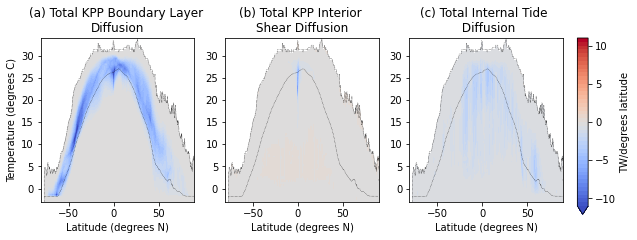

In [33]:
# masking:
maskPsi = 0*True_10year_means.Psi.sum('grid_xt_ocean').where(True_10year_means.Psi.sum('grid_xt_ocean')!=True_10year_means.Psi.sum('grid_xt_ocean').isel(neutralrho_edges=-1))+1.
maskHf = gridwm.interp(maskPsi,'T')
maskSF = gridwm.interp(maskPsi,'y',boundary="fill",fill_value=0.)
maskSF

Psicbar = np.arange(-24.,24.5,0.5)
Hfcbar = np.arange(-1.,1.05,0.05)
SFcbar = np.arange(-50.,51.,1.)
MXcbar = np.arange(-11.,11.5,0.5)


plt.figure(figsize=(10,3.5),facecolor='w')
cmap = 'coolwarm'
    
DataSet = True_10year_means

plt.subplot(1,3,1)
cbar1 = (DataSet.temp_vdiffuse_diff_cbt_kppbl.sum('grid_xt_ocean').where(maskSF==1.)/1.e12/dy).plot.contourf(levels=MXcbar,x='grid_yt_ocean',add_colorbar = False,cmap=cmap)
plot_min_temp()
plot_max_temp('SF')
plt.title('(a) Total KPP Boundary Layer \nDiffusion')
plt.ylabel('Temperature (degrees C)')
plt.xlabel('Latitude (degrees N)')

#MXcbar = np.arange(-4.5,4.6,0.1)

plt.subplot(1,3,2)
(DataSet.temp_vdiffuse_diff_cbt_kppish.sum('grid_xt_ocean').where(maskSF==1.)/1.e12/dy).plot.contourf(levels=MXcbar,x='grid_yt_ocean',add_colorbar = False,cmap=cmap)
plot_min_temp()
plot_max_temp('SF')
plt.title('(b) Total KPP Interior \nShear Diffusion')
plt.ylabel('')
plt.xlabel('Latitude (degrees N)')

plt.subplot(1,3,3)
(DataSet.temp_vdiffuse_diff_cbt_wave.sum('grid_xt_ocean').where(maskSF==1.)/1.e12/dy).plot.contourf(levels=MXcbar,x='grid_yt_ocean',add_colorbar = False,cmap=cmap)
plot_min_temp()
plot_max_temp('SF')
plt.title('(c) Total Internal Tide \n Diffusion')
plt.ylabel('')
plt.xlabel('Latitude (degrees N)')


ax_cb = plt.axes([0.87,0.1,0.015,0.7])
plt.colorbar(cbar1, cax = ax_cb, label = 'TW/degrees latitude',ticks = np.arange(-10.,10.1,5))

plt.subplots_adjust(wspace = 0.2, hspace = 0.4, right = 0.85, bottom = 0.15, top = 0.8 )
plt.savefig('/g/data/e14/cy8964/analysis/usyd/Overturning_decomposition/Paper-Code/Decompose_total_mixing_types.png',dpi = 200)
